<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="680" height="140" align="right"/>

<h4 style="text-align: center;">Curso: Proyecto de grado 2</h4>
<h4 style="text-align: center;">Tarea: Fase 1</h4>
<h4 style="text-align: center;">Presentado por: Oscar Andr√©s Russi Porras</h4>
<h4 style="text-align: center;">Universidad Nacional Abierta y a Distancia ‚Äì UNAD</h4>
<h4 style="text-align: center;">Fecha: Abril de 2025</h4>


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import datetime
from IPython.display import display
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

## Conectar datos

In [74]:
import urllib
from sqlalchemy import create_engine
import pandas as pd
columns_to_check = ['price', 'habitaciones', 'banyos', 'estrato', 'areaConstruida',
                        'areaPrivada', 'parqueaderos', 'administracion', 'pisoNumero', 'totalPisos']

params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-KNKLQ23\MSSQLSERVER01;DATABASE=inmuebles;"
    "UID=oscarrussi;PWD=asdf1234;"
)

# "mssql+pyodbc" es el dialecto para SQL Server a trav√©s de pyodbc
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [75]:
query = "select * from dbo.datosVivienda where (price is not null and price<>'') and (ubicacion is not null and ubicacion<>'')"
df = pd.read_sql(query, engine)

print(df.head())

            price  habitaciones  \
0    120000000.00          2.00   
1    105000000.00          1.00   
2   7850000000.00          1.00   
3  22000000000.00          1.00   
4 107158800000.00           NaN   

                                              descr  \
0                              Apartamento en venta   
1              Edificio en venta, Bogot√° - Germania   
2  Edificio en venta, Bogot√° - Primavera Occidental   
3                                   Bodega en venta   
4                                     Lote en venta   

                                                link  banyos       id  \
0  https://www.fincaraiz.com.co/apartamento-en-ve...    1.00  2351795   
1  https://www.fincaraiz.com.co/edificio-en-venta...     NaN  3056432   
2  https://www.fincaraiz.com.co/edificio-en-venta...    2.00  3072117   
3  https://www.fincaraiz.com.co/bodega-en-venta/3...     NaN  3129789   
4  https://www.fincaraiz.com.co/lote-en-venta/314...     NaN  3149801   

  tipoInmueble   

# Exploraci√≥n preliminar

## Caracterizaci√≥n general de la muestra 

In [76]:
pd.set_option('display.float_format', '{:.2f}'.format)
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos"]
summary = df[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

price  habitaciones   banyos  estrato  areaConstruida  \
count          12626.00      11551.00 11884.00 12479.00        12541.00   
mean     18526799529.32          2.85     2.57     4.04          149.26   
std     860106309561.06          4.31     1.98     1.32          171.12   
min             1000.00          0.00     0.00     1.00            0.00   
25%        256325000.00          2.00     1.00     3.00           52.00   
50%        484000000.00          3.00     2.00     4.00           81.00   
75%       1100000000.00          3.00     3.00     5.00          172.00   
max   95000000000000.00        400.00    60.00     7.00          998.00   

       areaPrivada  parqueaderos  administracion  pisoNumero  totalPisos  
count     11561.00       8163.00         7508.00     9906.00     9319.00  
mean        119.14          2.35      3097791.43        3.50        1.24  
std         165.71          3.32     43218820.61        4.08        2.86  
min           0.00         -1.00            0.00        0.00        0.00  
25%          30.00          1.00       144627.50        0.00        0.00  
50%          64.00          2.00       333600.00        2.00        0.00  
75%         134.00          2.00       730000.00        5.00        0.00  
max         998.00        127.00   2000000000.00       21.00       21.00

## Calidad de la informaci√≥n

In [77]:
df_nuevo = df
def discrete_variable_summary(df):
    summaries = []
    excluir = ['comodidades', 'date_created', 'date_modified']
    columnas_a_excluir = [col for col in excluir if col in df.columns]
    df_resultado = df.drop(columns=columnas_a_excluir)
    
    total = df.shape[0]  # total de registros incluyendo nulos
    
    for column in df_resultado.columns.tolist():
        # Moda sin nulos
        moda = df[column].mode(dropna=True)[0]
        freq = df[df[column] == moda].shape[0]
        total_no_nulos = df[column].count()
        perc = (freq / total_no_nulos) * 100 if total_no_nulos > 0 else 0

        # Nulos
        nulos = df[column].isna().sum()
        
        # Moda considerando nulos
        if nulos > freq:
            moda_nulos = np.nan
            freq_nulos = nulos
        else:
            moda_nulos = moda
            freq_nulos = freq
        
        perc_nulos = (freq_nulos / total) * 100 if total > 0 else 0

        summary = {
            'col': column,
            'uniques': df[column].nunique(),
            'mode': moda,
            'freq': freq,
            'perc': round(perc, 2),
            'mode_nulos': moda_nulos,
            'freq_nulos': freq_nulos,
            'perc_nulos': round(perc_nulos, 2)
        }
        summaries.append(summary)

    return pd.DataFrame(summaries)


discrete_variable_summary(df_nuevo)

col  uniques  \
0            price     1932   
1     habitaciones       29   
2            descr     1122   
3             link    12626   
4           banyos       24   
5               id    12626   
6     tipoInmueble       15   
7   estadoInmueble        6   
8   areaConstruida     1275   
9      areaPrivada     1115   
10      antiguedad        7   
11    parqueaderos       28   
12  administracion     1797   
13      pisoNumero       22   
14      totalPisos       20   
15       ubicacion      981   
16         estrato        7   

                                                 mode   freq  perc  \
0                                        450000000.00    140  1.11   
1                                                3.00   4936 42.73   
2                                Apartamento en Venta   5389 42.68   
3   https://www.fincaraiz.com.co/apartaestudio-en-...      1  0.01   
4                                                2.00   4378 36.84   
5                                             2351795      1  0.01   
6                                         Apartamento   7840 62.19   
7                                        ¬°Preg√∫ntale!  11666 92.54   
8                                               60.00    181  1.44   
9                                                0.00   2158 18.67   
10                                       16 a 30 a√±os   3694 29.26   
11                                               1.00   3822 46.82   
12                                               0.00    693  9.23   
13                                               0.00   3265 32.96   
14                                               0.00   7024 75.37   
15                      Usaquen, Bogot√°, Bogot√°, d.c.    574  4.55   
16                                               3.00   3675 29.45   

                                           mode_nulos  freq_nulos  perc_nulos  
0                                        450000000.00         140        1.11  
1                                                3.00        4936       39.09  
2                                Apartamento en Venta        5389       42.68  
3   https://www.fincaraiz.com.co/apartaestudio-en-...           1        0.01  
4                                                2.00        4378       34.67  
5                                             2351795           1        0.01  
6                                         Apartamento        7840       62.09  
7                                        ¬°Preg√∫ntale!       11666       92.40  
8                                               60.00         181        1.43  
9                                                0.00        2158       17.09  
10                                       16 a 30 a√±os        3694       29.26  
11                                                NaN        4463       35.35  
12                                                NaN        5118       40.54  
13                                               0.00        3265       25.86  
14                                               0.00        7024       55.63  
15                      Usaquen, Bogot√°, Bogot√°, d.c.         574        4.55  
16                                               3.00        3675       29.11

## Distribuci√≥n de los datos

In [78]:
print(df_nuevo["antiguedad"].unique())
# Diccionario de codificaci√≥n
map_antiguedad = {
    "menor a 1 a√±o": 0,
    "1 a 8 a√±os": 1,
    "9 a 15 a√±os": 2,
    "16 a 30 a√±os": 3,
    "m√°s de 30 a√±os": 4,
    "¬°Preg√∫ntale!": None
}

# Reemplazar valores vac√≠os por NaN
df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace('', np.nan)

# Aplicar codificaci√≥n
df_nuevo["antiguedad_encoded"] = df_nuevo["antiguedad"].map(map_antiguedad)

# Imputar valores faltantes con la moda
moda = df_nuevo["antiguedad_encoded"].mode()[0]
df_nuevo["antiguedad_encoded"].fillna(moda, inplace=True)

# Aseg√∫rate de que la columna est√© en tipo num√©rico
print(df_nuevo["antiguedad_encoded"].unique())



['9 a 15 a√±os' 'menor a 1 a√±o' '16 a 30 a√±os' '¬°Preg√∫ntale!' '1 a 8 a√±os'
 'm√°s de 30 a√±os' '']
[2. 0. 3. 1. 4.]


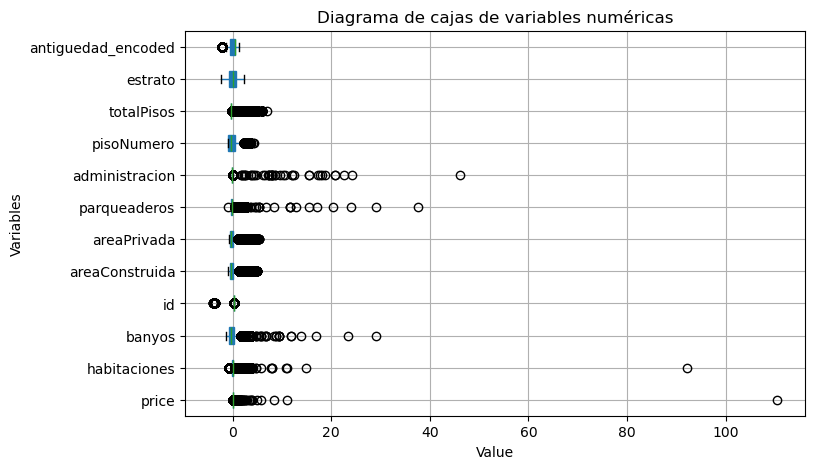

In [79]:
def clasificar_variable(tipo):
    if pd.api.types.is_numeric_dtype(tipo):
        return 'Num√©rica'
    elif pd.api.types.is_string_dtype(tipo):
        return 'Categ√≥rica'
    else:
        return 'Otra'



def create_box(df_):
    numerics = [num for num in df_.columns if clasificar_variable(df_[num].dtype)=='Num√©rica']
    scaler = StandardScaler()
    # Create a copy of the DataFrame and normalize the selected columns
    df_normalized = df_[numerics].copy()
    df_normalized[numerics] = scaler.fit_transform(df_[numerics])
    # Create the horizontal boxplot
    plt.figure(figsize=(8, 5))
    df_normalized.boxplot(vert=False, patch_artist=True)
    # Set the title, labels, and y-ticks
    plt.title('Diagrama de cajas de variables num√©ricas')
    plt.xlabel('Value')
    plt.ylabel('Variables')
    plt.yticks(ticks=range(1, len(numerics) + 1), labels=numerics)  # Set labels based on column names
    plt.grid(True)
    plt.show()

create_box(df_nuevo)

## Relaciones entre variables num√©ricas

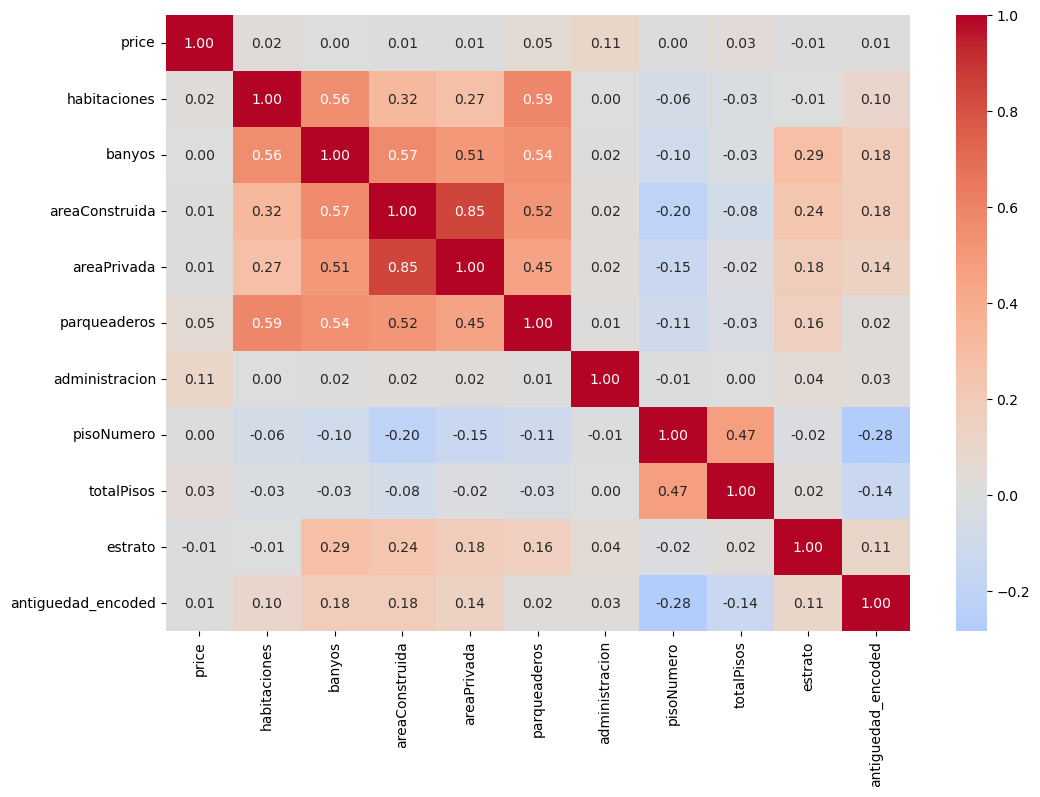

In [80]:
numerics = [num for num in df_nuevo.columns if clasificar_variable(df_nuevo[num].dtype)=='Num√©rica' and num!="id"]

def corr_matrix(df_):
    # Assuming df_hotels_booking is your DataFrame and 'numerics' is a list of numeric columns
    correlation_matrix = df_.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.show()  # display the heatmap

corr_matrix(df_nuevo[numerics])

# Limpieza de datos

In [81]:
trash_columns = ['descr', 'link','id','date_modified','date_created']
df_nuevo = df.drop(columns=trash_columns)
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12626 entries, 0 to 12625
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               12626 non-null  float64
 1   habitaciones        11551 non-null  float64
 2   banyos              11884 non-null  float64
 3   tipoInmueble        12606 non-null  object 
 4   estadoInmueble      12606 non-null  object 
 5   areaConstruida      12541 non-null  float64
 6   areaPrivada         11561 non-null  float64
 7   antiguedad          12606 non-null  object 
 8   parqueaderos        8163 non-null   float64
 9   administracion      7508 non-null   float64
 10  pisoNumero          9906 non-null   float64
 11  totalPisos          9319 non-null   float64
 12  comodidades         10719 non-null  object 
 13  ubicacion           12626 non-null  object 
 14  estrato             12479 non-null  float64
 15  antiguedad_encoded  12626 non-null  float64
dtypes: f

In [82]:
print(f"records before cleaning dataframe: {df_nuevo.count()}")
def clean_dataframe(df_):
    # Remove rows with negative values, ignoring NaNs
    for col in columns_to_check:
        df_ = df_[(df_[col] >= 0) | (df_[col].isnull())]

    print(f"Total rows after removing negatives: {df_.shape[0]}")

    # Remove rows where 'estrato' is greater than 6, ignoring NaNs
    df_ = df_[(df_['estrato'] <= 6) | (df_['estrato'].isnull())]

    df_['estadoInmueble'] = df_['estadoInmueble'].replace('¬°Preg√∫ntale!', np.nan)
    # Reset the DataFrame index
    df_.reset_index(drop=True, inplace=True)

    return df_

df_cleaned=clean_dataframe(df_nuevo)
print(f"records after cleaning dataframe: {df_cleaned.count()}")

records before cleaning dataframe: price                 12626
habitaciones          11551
banyos                11884
tipoInmueble          12606
estadoInmueble        12606
areaConstruida        12541
areaPrivada           11561
antiguedad            12606
parqueaderos           8163
administracion         7508
pisoNumero             9906
totalPisos             9319
comodidades           10719
ubicacion             12626
estrato               12479
antiguedad_encoded    12626
dtype: int64
Total rows after removing negatives: 12625
records after cleaning dataframe: price                 12618
habitaciones          11547
banyos                11880
tipoInmueble          12598
estadoInmueble          940
areaConstruida        12534
areaPrivada           11557
antiguedad            12598
parqueaderos           8161
administracion         7508
pisoNumero             9903
totalPisos             9316
comodidades           10715
ubicacion             12618
estrato               12471
antigue

In [83]:
import numpy as np
import pandas as pd

def iqr_skew_adjusted_bounds(series, factor=3.0):
    """
    Returns (lower_bound, upper_bound) for outlier detection
    using an IQR-based rule adjusted by a log-skew factor.
    If Q1 == Q3 == 0, applies a log1p transformation to spread the distribution first.
    """
    print(series.name)
    valid = series.dropna()

    # If series is empty or all identical values
    if valid.nunique() <= 1:
        return (-np.inf, np.inf)

    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)

    # Check for flat IQR caused by extreme skew or zero dominance
    if Q1 == 0 and Q3 == 0:
        print(f"Column: {series.name} has Q1 = Q3 = 0, applying log1p transform")
        valid = np.log1p(valid)
        Q1 = valid.quantile(0.25)
        Q3 = valid.quantile(0.75)

    IQR = Q3 - Q1
    mean_val = valid.mean()
    median_val = valid.median()

    # Fallback if median <= 0 or IQR is too small
    if median_val <= 0 or np.isnan(mean_val) or IQR == 0:
        std = valid.std()
        mean_val = valid.mean()
        if np.isnan(std) or std == 0:
            return (-np.inf, np.inf)  # can't calculate anything useful
        print(f"Column: {series.name} ‚Äî Using mean ¬± {factor} √ó std as fallback")
        return (mean_val - factor * std, mean_val + factor * std)

    log_skew_factor = (mean_val / median_val) ** 0.72
    print(f"Column: {series.name}, log skew factor: {log_skew_factor:.3f}, "
          f"mean: {mean_val:.1f}, median: {median_val:.1f}, IQR: {IQR:.3f}, Q1: {Q1:.3f}, Q3: {Q3:.3f}")

    subs_left = factor * IQR * (1 / log_skew_factor) if log_skew_factor != 0 else factor * IQR
    add_right = factor * IQR * log_skew_factor
    lower_bound = Q1 - subs_left
    upper_bound = Q3 + add_right
    print(f"column: {series.name}, lower bound is {lower_bound:.3f}, upper bound is {upper_bound:.3f}, "
          f"subs left: {subs_left:.3f}, add right: {add_right:.3f}")
    return lower_bound, upper_bound


def remove_outliers_iqr_skew_all(df, factor=3.0):
    """
    Applies the iqr_skew_adjusted_bounds to each numeric column in df.
    A row is removed if it is an outlier in ANY numeric column.
    Returns a new DataFrame with those rows removed.
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Start with a mask of all True
    mask = pd.Series(True, index=df.index)
    
    # For each numeric column, compute skew-adjusted IQR bounds, then refine the mask
    for col in numeric_cols:
        lb, ub = iqr_skew_adjusted_bounds(df[col], factor=factor)
        
        # Keep rows that are NaN or within [lb, ub]
        col_mask = df[col].isna() | ((df[col] >= lb) & (df[col] <= ub))
        mask &= col_mask  # logical AND: row must be non-outlier in ALL numeric cols
    
    # Return filtered DataFrame
    return df[mask].reset_index(drop=True)

df_no_outliers = remove_outliers_iqr_skew_all(df_cleaned, factor=4.0)

price
Column: price, log skew factor: 13.790, mean: 18516574168.4, median: 484000000.0, IQR: 843000000.000, Q1: 257000000.000, Q3: 1100000000.000
column: price, lower bound is 12469764.450, upper bound is 47598887855.033, subs left: 244530235.550, add right: 46498887855.033
habitaciones
Column: habitaciones, log skew factor: 0.963, mean: 2.8, median: 3.0, IQR: 1.000, Q1: 2.000, Q3: 3.000
column: habitaciones, lower bound is -2.154, upper bound is 6.852, subs left: 4.154, add right: 3.852
banyos
Column: banyos, log skew factor: 1.198, mean: 2.6, median: 2.0, IQR: 2.000, Q1: 1.000, Q3: 3.000
column: banyos, lower bound is -5.675, upper bound is 12.588, subs left: 6.675, add right: 9.588
areaConstruida
Column: areaConstruida, log skew factor: 1.553, mean: 149.3, median: 81.0, IQR: 120.000, Q1: 52.000, Q3: 172.000
column: areaConstruida, lower bound is -257.062, upper bound is 917.482, subs left: 309.062, add right: 745.482
areaPrivada
Column: areaPrivada, log skew factor: 1.564, mean: 119

# An√°lisis descriptivo post-limpieza

## Caracterizaci√≥n general de la muestra

In [84]:
summary = df_no_outliers[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

price  habitaciones  banyos  estrato  areaConstruida  \
count       10091.00       9382.00 9536.00  9977.00        10039.00   
mean   1274728553.50          2.53    2.30     4.03          124.85   
std    3274418057.97          1.20    1.34     1.31          129.96   
min      13000000.00          0.00    0.00     1.00            0.00   
25%     249410000.00          2.00    1.00     3.00           50.00   
50%     448000000.00          3.00    2.00     4.00           76.00   
75%     900000000.00          3.00    3.00     5.00          147.00   
max   44150000000.00          6.00   10.00     6.00          917.00   

       areaPrivada  parqueaderos  administracion  pisoNumero  totalPisos  
count      9369.00       6332.00         6124.00     8095.00     7522.00  
mean         93.81          1.78       543412.14        3.06        0.25  
std         119.45          1.06       672020.64        3.90        0.73  
min           0.00          1.00            0.00        0.00        0.00  
25%          20.00          1.00       139000.00        0.00        0.00  
50%          59.00          1.00       321000.00        2.00        0.00  
75%         112.00          2.00       700000.00        5.00        0.00  
max         781.00          6.00      7500000.00       20.00        3.00

* La mayor√≠a de los inmuebles registrados corresponden a apartamentos con entre 2 y 3 habitaciones y 2 ba√±os, configuraciones que reflejan un mercado dirigido principalmente a viviendas familiares o de gama media, en l√≠nea con la estructura t√≠pica del mercado inmobiliario de Bogot√°.
* 	Las variables f√≠sicas, como habitaciones, ba√±os y parqueaderos, tienden a concentrarse en valores bajos o medios, siendo comunes los inmuebles con 1 parqueadero y ubicados en edificios de hasta 2 pisos
* √Å	√°reaConstruida y √°reaPrivada mantienen una relaci√≥n directa y elevada, lo cual es consistente con la naturaleza propia de estas variables, donde el √°rea privada constituye una proporci√≥n significativa del √°rea construid
* L‚Ä¢ La variable estrato presenta una moda en el valor 3 y seis categor√≠as distintas, lo que concuerda con la segmentaci√≥n oficial de estratos socioecon√≥micos en Bogot√° y su distribuci√≥n en la oferta inmobiliaria de la ciudd.


## Calidad de la informaci√≥n

In [85]:
discrete_variable_summary(df_no_outliers)

col  uniques                           mode  freq  perc  \
0                price     1494                   350000000.00   120  1.19   
1         habitaciones        7                           3.00  4109 43.80   
2               banyos       11                           2.00  3649 38.27   
3         tipoInmueble       15                    Apartamento  6376 63.31   
4       estadoInmueble        4                Excelenteestado   405 54.80   
5       areaConstruida     1012                          50.00   153  1.52   
6          areaPrivada      873                           0.00  1934 20.64   
7           antiguedad        6                   16 a 30 a√±os  2993 29.72   
8         parqueaderos        6                           1.00  3197 50.49   
9       administracion     1561                           0.00   628 10.25   
10          pisoNumero       21                           0.00  2885 35.64   
11          totalPisos        4                           0.00  6609 87.86   
12           ubicacion      901  Usaquen, Bogot√°, Bogot√°, d.c.   478  4.74   
13             estrato        6                           3.00  2968 29.75   
14  antiguedad_encoded        5                           3.00  3655 36.22   

                       mode_nulos  freq_nulos  perc_nulos  
0                    350000000.00         120        1.19  
1                            3.00        4109       40.72  
2                            2.00        3649       36.16  
3                     Apartamento        6376       63.19  
4                             NaN        9352       92.68  
5                           50.00         153        1.52  
6                            0.00        1934       19.17  
7                    16 a 30 a√±os        2993       29.66  
8                             NaN        3759       37.25  
9                             NaN        3967       39.31  
10                           0.00        2885       28.59  
11                           0.00        6609       65.49  
12  Usaquen, Bogot√°, Bogot√°, d.c.         478        4.74  
13                           3.00        2968       29.41  
14                           3.00        3655       36.22

* La variable estadoInmueble presenta cerca del 90% de registros sin informaci√≥n, luego de sustituir el placeholder ¬°Preg√∫ntale! por valores nulos. Esto sugiere que es una caracter√≠stica que frecuentemente no es diligenciada durante el registro de los inmuebles.
* 	Variables como areaPrivada y administracion muestran que, al incluir los nulos, estos se convierten en la moda, evidenciando una falta sistem√°tica de informaci√≥n o baja prioridad en su registro
* ‚Ä¢	Otras variables, como parqueaderos y pisoNumero, tambi√©n presentan porcentajes considerables de valores nulos, posiblemente asociados a caracter√≠sticas no siempre presentes o consideradas en ciertos tipos de inmueble.


## Distribuci√≥n de los datos

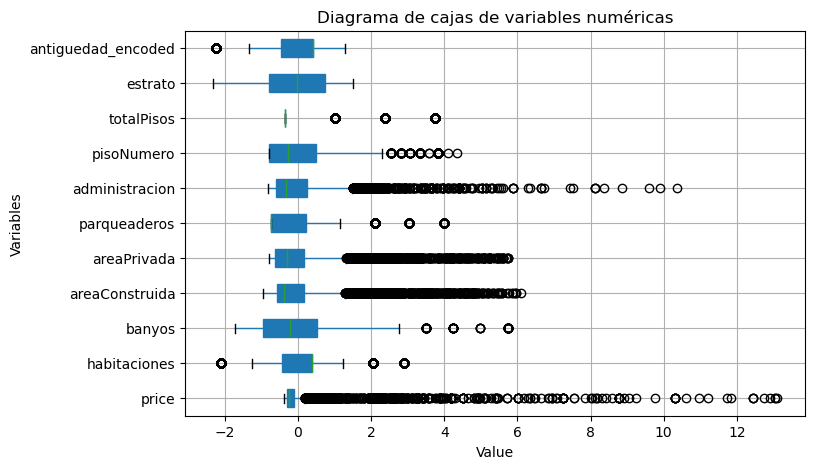

In [86]:
create_box(df_no_outliers)

* Variables como administraci√≥n, √°reaConstruida, √°reaPrivada y price presentan numerosos valores at√≠picos, lo que sugiere una alta variabilidad en estas caracter√≠sticas y posibles registros con errores o inmuebles significativamente diferentes al promedio.
* Por el contrario, variables como estrato, totalPisos, ba√±os, habitaciones y parqueaderos muestran distribuciones relativamente sim√©tricas, lo que refleja consistencia en los datos recopilados. Sin embargo, variables como administraci√≥n, √°reaConstruida, √°reaPrivada y, especialmente, price, exhiben una mayor dispersi√≥n, indicando una oferta diversa en cuanto a caracter√≠sticas f√≠sicas y precios de los inmuebles.

## Principales hallazgos de correlaci√≥n

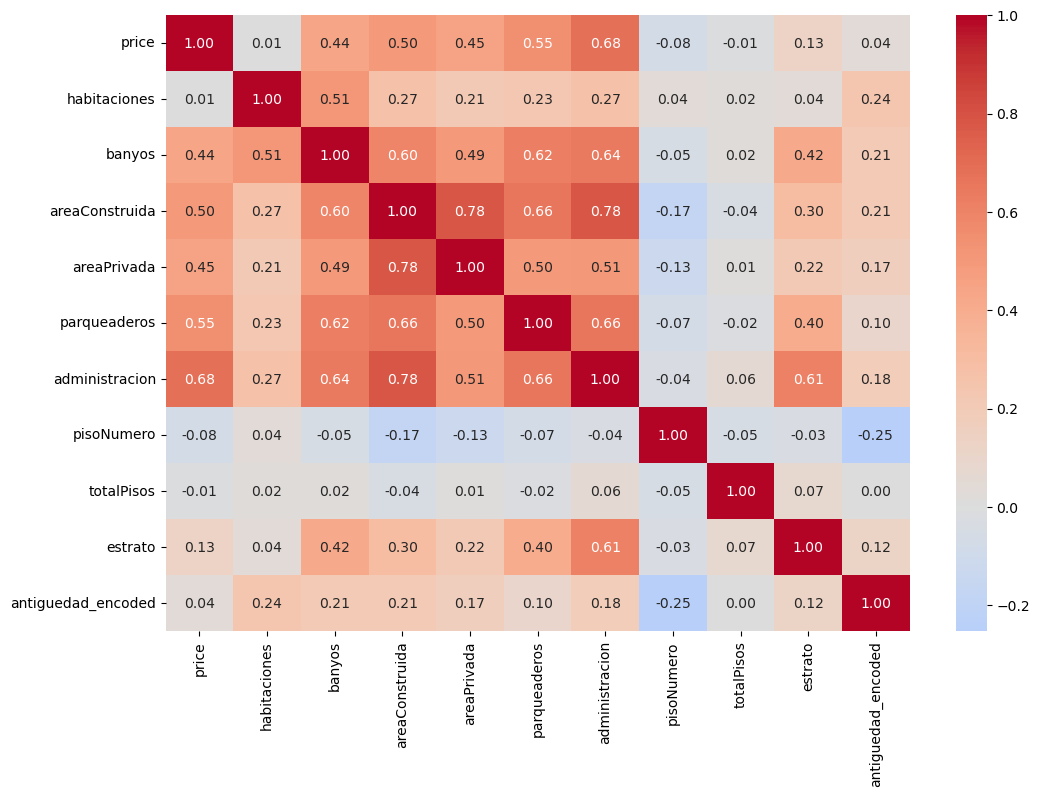

In [87]:
corr_matrix(df_no_outliers[numerics])

* Se observa una correlaci√≥n fuerte entre administracion, areaConstruida, parqueaderos y ba√±os con price, lo que sugiere que las dimensiones y equipamiento f√≠sico de las propiedades tienen un impacto significativo en su valor.
* 	Aunque estrato muestra una relaci√≥n moderada con la cuota de administraci√≥n y algunas caracter√≠sticas f√≠sicas como el n√∫mero de ba√±os, su relaci√≥n directa con el precio es d√©bil. Este comportamiento es consistente con la din√°mica inmobiliaria de Bogot√°, donde es com√∫n encontrar inmuebles de alto valor tanto en estratos medios como en estratos altos, debido a la influencia de factores como ubicaci√≥n, estado de conservaci√≥n o caracter√≠sticas adicionales
* ‚Ä¢	Finalmente, variables como pisoNumero, totalPisos y habitaciones presentan una influencia reducida sobre el precio, indicando que no son determinantes relevantes en la variabilidad del valor de los inmuebles en la muestra analizad.


## limpieza de datos

In [88]:
mapa_antiguedad = {
    "menor a 1 a√±o": 1,
    "1 a 8 a√±os": 2,
    "9 a 15 a√±os": 3,
    "16 a 30 a√±os": 4,
    "m√°s de 30 a√±os": 5,
    "¬°Preg√∫ntale!": np.nan  # por ejemplo, puedes marcarlo como NaN
}

df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace(mapa_antiguedad)
df_nuevo.sample(5)

price  habitaciones  banyos tipoInmueble   estadoInmueble  \
529   105000000.00          3.00    1.00         Casa     ¬°Preg√∫ntale!   
2776  479000000.00          1.00    2.00  Apartamento     ¬°Preg√∫ntale!   
3266  301800000.00          4.00    2.00         Casa  Excelenteestado   
2050 4300000000.00          3.00    3.00  Apartamento     ¬°Preg√∫ntale!   
196   120000000.00          2.00    1.00  Apartamento       Buenestado   

      areaConstruida  areaPrivada  antiguedad  parqueaderos  administracion  \
529            11.00        11.00        3.00           NaN             NaN   
2776           74.00        74.00        4.00          2.00       480000.00   
3266           77.00        77.00        5.00           NaN             NaN   
2050          350.00          NaN        4.00          4.00      2000000.00   
196            35.00        32.00        2.00           NaN       117500.00   

      pisoNumero  totalPisos  \
529          NaN         NaN   
2776        5.00        5.00   
3266         NaN         NaN   
2050         NaN         NaN   
196         9.00        9.00   

                                            comodidades  \
529   ‚Ä¢Alarma‚Ä¢En conjunto cerrado‚Ä¢Instalaci√≥n de gas...   
2776  ‚Ä¢Ascensor‚Ä¢Balc√≥n‚Ä¢Calentador‚Ä¢Canchas Deportivas...   
3266                            ‚Ä¢Parqueadero Visitantes   
2050  ‚Ä¢Ascensor‚Ä¢Balc√≥n‚Ä¢Chimenea‚Ä¢Cit√≥fono‚Ä¢Cocina Equi...   
196   ‚Ä¢Ascensor‚Ä¢Barra estilo americano‚Ä¢Ba√±o Auxiliar...   

                                         ubicacion  estrato  \
529               Valparaiso, Bogot√°, Bogot√°, d.c.     2.00   
2776                Pasadena, Bogot√°, Bogot√°, d.c.     5.00   
3266                Engativ√°, Bogot√°, Bogot√°, d.c.     3.00   
2050      Santa barbara alta, Bogot√°, Bogot√°, d.c.     6.00   
196   Las vegas de santa ana, Bogot√°, Bogot√°, d.c.     2.00   

      antiguedad_encoded  
529                 2.00  
2776                3.00  
3266                4.00  
2050                3.00  
196                 1.00

In [89]:
# Reemplazar NaN con cadena vac√≠a para evitar problemas
df_no_outliers['comodidades'] = df_no_outliers['comodidades'].fillna('')

# Generar las columnas de comodidades (multi-hot encoding)
df_comodidades = df_no_outliers['comodidades'].str.get_dummies(sep='‚Ä¢')

# Unir al DataFrame original
df_final = df_no_outliers.join(df_comodidades)
df_final = df_final.drop(columns=["comodidades"])
df_final.columns

Index(['price', 'habitaciones', 'banyos', 'tipoInmueble', 'estadoInmueble',
       'areaConstruida', 'areaPrivada', 'antiguedad', 'parqueaderos',
       'administracion',
       ...
       'Zona Residencial', 'Zona de BBQ', 'Zona de Camping',
       'Zona de lavander√≠a', 'Zonas Verdes', 'Zonas Verdes\r',
       '√Årboles frutales', '√Årea Rural', '√Årea Urbana', '√Årea Urbana\r'],
      dtype='object', length=218)

In [90]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Reemplazar cadenas vac√≠as
df_final = df_final.replace('', np.nan)

# Seleccionar solo columnas num√©ricas
numeric_cols = df_final.select_dtypes(include=['int64', 'float64']).columns

# Escalar solo esas columnas
scaler = StandardScaler()
df_scaled = df_final.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Ver muestra
df_scaled.sample(5)

price  habitaciones  banyos tipoInmueble estadoInmueble  areaConstruida  \
2363   0.03          1.22    1.26  Apartamento            NaN            0.49   
3157  -0.32          0.39   -0.22  Apartamento            NaN           -0.51   
8143   0.05         -2.10   -1.71      Oficina            NaN           -0.53   
101   -0.38         -1.27    1.26        Local     Buenestado           -0.91   
6774  -0.23         -0.44    0.52  Apartamento            NaN           -0.35   

      areaPrivada    antiguedad  parqueaderos  administracion  ...  \
2363         0.79  16 a 30 a√±os          0.21             NaN  ...   
3157        -0.30    1 a 8 a√±os           NaN           -0.66  ...   
8143        -0.79  16 a 30 a√±os          1.15             NaN  ...   
101         -0.73  16 a 30 a√±os           NaN             NaN  ...   
6774        -0.12  ¬°Preg√∫ntale!         -0.74           -0.15  ...   

      Zona Residencial  Zona de BBQ Zona de Camping  Zona de lavander√≠a  \
2363             -0.43        -0.18           -0.01               -0.34   
3157             -0.43        -0.18           -0.01               -0.34   
8143             -0.43        -0.18           -0.01               -0.34   
101              -0.43        -0.18           -0.01               -0.34   
6774             -0.43        -0.18           -0.01               -0.34   

      Zonas Verdes  Zonas Verdes\r  √Årboles frutales  √Årea Rural  √Årea Urbana  \
2363         -0.19           -0.01             -0.03       -0.05        -0.20   
3157         -0.19           -0.01             -0.03       -0.05        -0.20   
8143         -0.19           -0.01             -0.03       -0.05        -0.20   
101          -0.19           -0.01             -0.03       -0.05        -0.20   
6774         -0.19           -0.01             -0.03       -0.05        -0.20   

      √Årea Urbana\r  
2363          -0.01  
3157          -0.01  
8143          -0.01  
101           -0.01  
6774          -0.01  

[5 rows x 218 columns]

In [91]:
dummy_columns =["tipoInmueble", "estadoInmueble", "ubicacion"]
df_encoded = pd.get_dummies(
    df_scaled,
    columns=dummy_columns
    #,drop_first=True  # This will drop the first category, preventing unnecessary columns
)

df_encoded.columns

Index(['price', 'habitaciones', 'banyos', 'areaConstruida', 'areaPrivada',
       'antiguedad', 'parqueaderos', 'administracion', 'pisoNumero',
       'totalPisos',
       ...
       'ubicacion_Zona Noroccidente, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona centro, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona chapinero, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona franca, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona industrial cazuca, Bogot√°, Cundinamarca',
       'ubicacion_Zona industrial, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona nororiental, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona norte, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona occidental, Bogot√°, Bogot√°, d.c.',
       'ubicacion_Zona sur, Bogot√°, Bogot√°, d.c.'],
      dtype='object', length=1135)

In [92]:
# Show count and percentage of nulls per column
nulls = df_encoded.isnull().sum().to_frame(name='null_count')
nulls['null_percentage'] = 100 * nulls['null_count'] / len(df)

print(nulls[nulls['null_count']>0])

                null_count  null_percentage
habitaciones           709             5.62
banyos                 555             4.40
areaConstruida          52             0.41
areaPrivada            722             5.72
antiguedad              20             0.16
parqueaderos          3759            29.77
administracion        3967            31.42
pisoNumero            1996            15.81
totalPisos            2569            20.35
estrato                114             0.90


In [93]:
#df_encoded["administracion"] = df_encoded["administracion"].fillna(0)
#df_encoded["parqueaderos"] = df_encoded["parqueaderos"].fillna(0)
#df_encoded["habitaciones"] = df_encoded["habitaciones"].fillna(0)
#df_encoded["banyos"] = df_encoded["banyos"].fillna(0)
#df_encoded["areaConstruida"] = df_encoded["areaConstruida"].fillna(0)
#df_encoded["pisoNumero"] = df_encoded["pisoNumero"].fillna(0)
#df_encoded["areaPrivada"] = df_encoded["areaPrivada"].fillna(0)
#df_encoded["totalPisos"] = df_encoded["totalPisos"].fillna(0)
#df_encoded["estrato"] = df_encoded["estrato"].fillna(0)

df_encoded = df_encoded.dropna()

# 1. Definir etiquetas
# etiquetas = [1,2,3,4,5,6,7]

# # 2. Calcular los l√≠mites (min y max del price)
# min_price = df_encoded['price'].min()
# max_price = df_encoded['price'].max()

# # 3. Generar los bins (l√≠mites de categor√≠a)
# bins = np.linspace(min_price, max_price, num=len(etiquetas)+1)

# # 4. Crear nueva columna categ√≥rica
# df_encoded['range_price'] = pd.cut(df_encoded['price'], bins=bins, labels=etiquetas, include_lowest=True)

if "antiguedad" in df_encoded.columns:
    df_encoded=df_encoded.drop(columns=["antiguedad"])


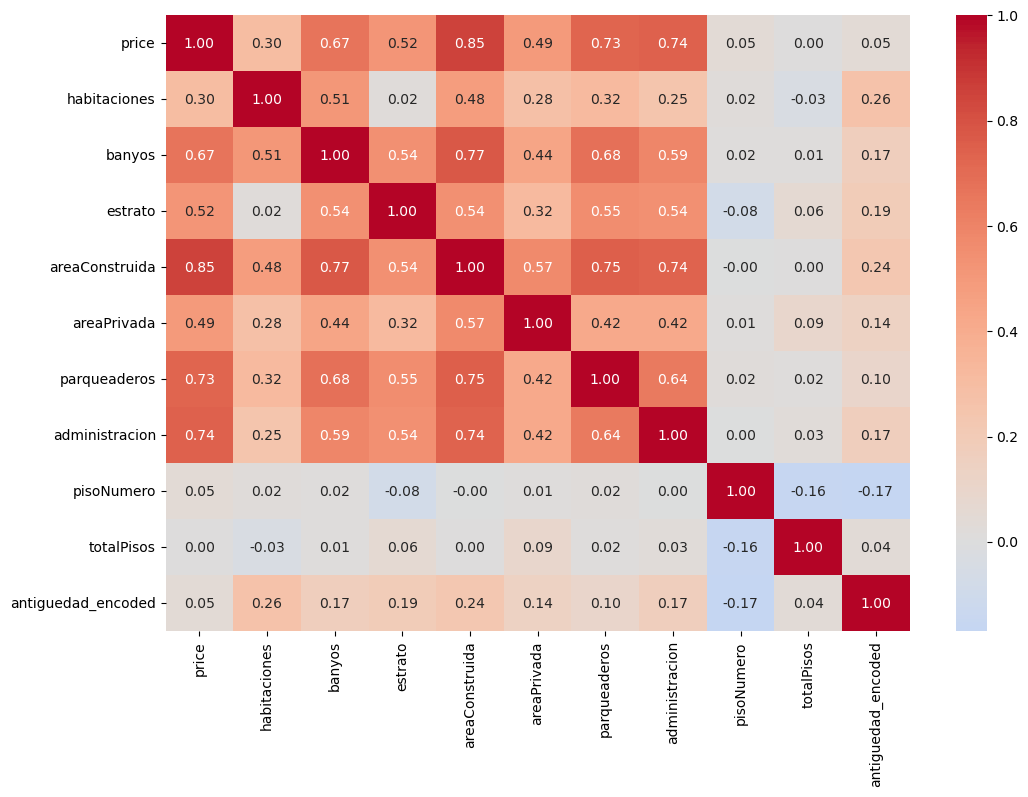

In [94]:
new_main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos","antiguedad_encoded"]
corr_matrix(df_encoded[new_main_columns])

## Visualizaci√≥n exploratoria de las variables

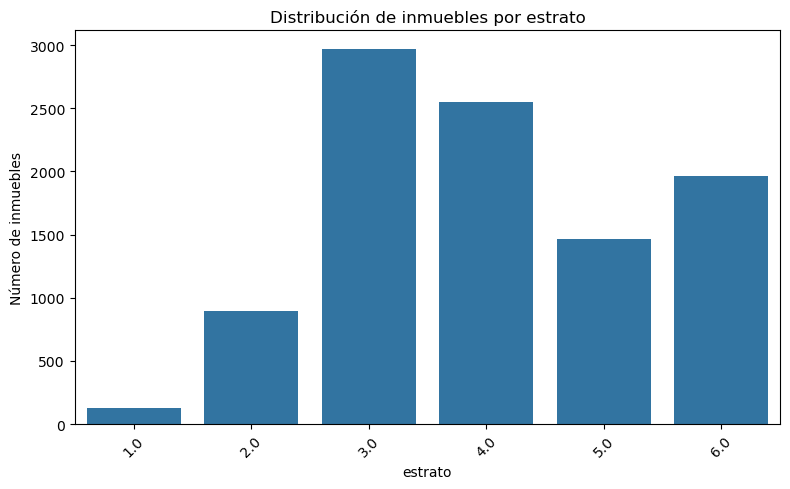

In [95]:
# Suponiendo que tu dataframe se llama df y tiene la columna 'estrato'
# Contar la cantidad de inmuebles por estrato


def bar_plot(df_,variable):
    # Crear el barplot
    conteo_estrato = df_[variable].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=conteo_estrato.index, y=conteo_estrato.values)
    # Etiquetas y t√≠tulo
    plt.xlabel(variable)
    plt.ylabel('N√∫mero de inmuebles')
    plt.title(f'Distribuci√≥n de inmuebles por {variable}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Mostrar gr√°fico
    plt.show()

bar_plot(df_no_outliers, "estrato")

En la Figura se presenta la distribuci√≥n de inmuebles seg√∫n el estrato socioecon√≥mico. Se observa que la mayor concentraci√≥n de inmuebles corresponde al estrato 3, seguido por los estratos 4 y 6. Esto refleja una predominancia de la oferta inmobiliaria en estratos medios, lo cual es consistente con la estructura socioecon√≥mica y la din√°mica urbana de Bogot√°. Por otro lado, los inmuebles de estrato 1 representan una proporci√≥n significativamente menor dentro de la muestra analizada.

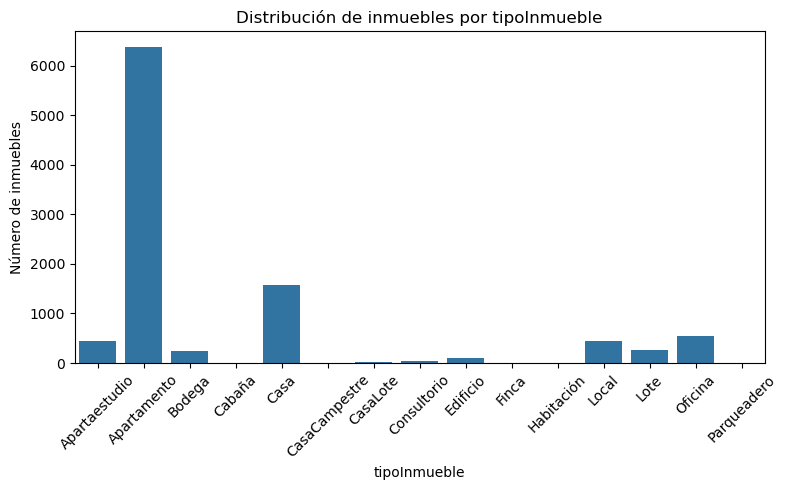

In [96]:
bar_plot(df_no_outliers, "tipoInmueble")

La Figura muestra la distribuci√≥n de inmuebles seg√∫n el tipo de inmueble. Se evidencia una clara predominancia de apartamentos, representando la categor√≠a con mayor cantidad de registros. Este comportamiento es consistente con el perfil urbano de la ciudad, donde los apartamentos constituyen una de las opciones habitacionales m√°s comunes. Otros tipos de inmuebles como casas, oficinas y locales presentan una frecuencia mucho menor, mientras que categor√≠as como consultorios, casas campestres, o lotes tienen una representaci√≥n residual en la muestra. Esta distribuci√≥n confirma que la oferta inmobiliaria en Bogot√° est√° mayoritariamente orientada hacia el mercado residencial multifamiliar.

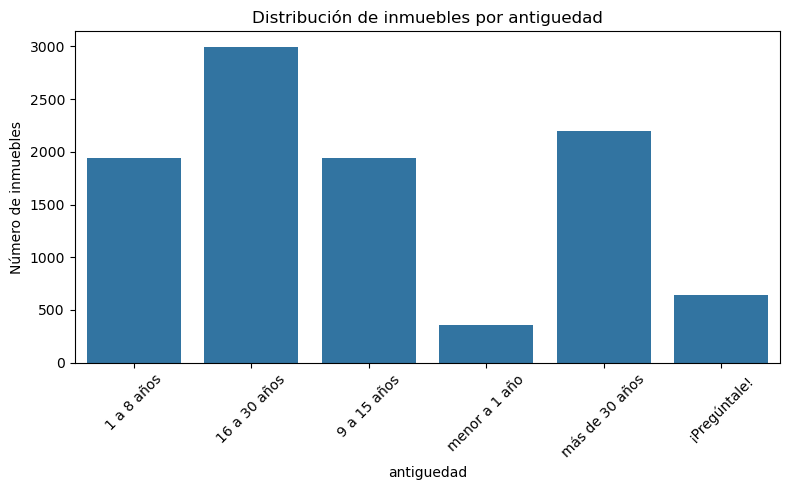

In [97]:
bar_plot(df_no_outliers, "antiguedad")

* En la Figura se presenta la distribuci√≥n de inmuebles seg√∫n su antig√ºedad. Se observa que la mayor√≠a de los inmuebles tienen entre 16 y 30 a√±os de construcci√≥n, seguidos por aquellos con m√°s de 30 a√±os y por inmuebles de entre 9 a 15 a√±os. Este comportamiento es coherente con el desarrollo urbano de Bogot√°, donde muchas edificaciones fueron construidas durante el auge de crecimiento inmobiliario de finales del siglo XX y principios del XXI.* 
Tambi√©n se evidencia que las viviendas de menos de 1 a√±o representan una proporci√≥n peque√±a, indicando una menor cantidad de proyectos recientes en la muestra recopilada. Por otro lado, una cantidad significativa de registros contiene la etiqueta ¬°Preg√∫ntale!, la cual se identifica como un placeholder, lo que revela que la antig√ºedad de algunos inmuebles no fue diligenciada en la fuente de datos.


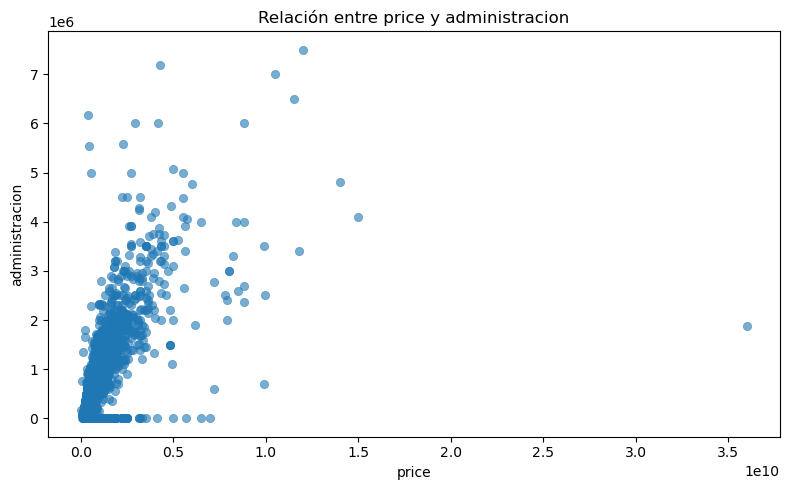

In [98]:
def scatter_plot(df, col_x, col_y):
    """
    Genera un scatter plot entre dos columnas de un dataframe.

    Par√°metros:
    - df: dataframe que contiene los datos
    - col_x: nombre de la columna para el eje X (string)
    - col_y: nombre de la columna para el eje Y (string)
    """
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x=col_x, y=col_y, alpha=0.6, edgecolor=None)

    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(f"Relaci√≥n entre {col_x} y {col_y}")
    plt.tight_layout()
    plt.show()

scatter_plot(df_no_outliers,"price","administracion")


* En la Figura se observa la relaci√≥n entre el precio de los inmuebles y el valor de la cuota de administraci√≥n. Se evidencia una relaci√≥n positiva entre ambas variables, donde en general, inmuebles con precios m√°s altos tienden a asociarse con cuotas de administraci√≥n m√°s elevadas. No obstante, la dispersi√≥n es significativa, especialmente en rangos intermedios, lo que sugiere que inmuebles de precios similares pueden tener costos de administraci√≥n muy variables, posiblemente debido a diferencias en servicios, ubicaci√≥n o tipo de propiedad.* 
Tambi√©n se identifican algunos valores extremos, tanto en precios como en administraci√≥n, que podr√≠an representar inmuebles at√≠picos o errores de captura. Esta relaci√≥n positiva es consistente con la correlaci√≥n num√©rica previamente observada y respalda la hip√≥tesis de que las caracter√≠sticas f√≠sicas y de servicios de los inmuebles inciden en su precio de venta


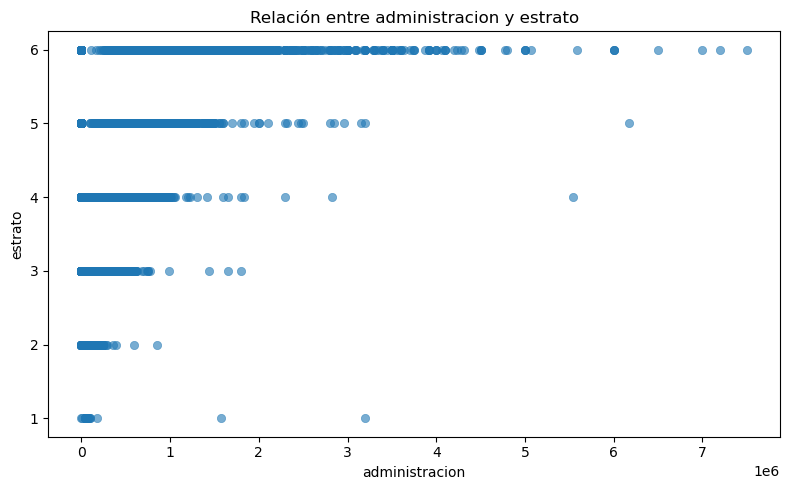

In [99]:
scatter_plot(df_no_outliers,"administracion","estrato")

En la Figura se presenta la relaci√≥n entre el valor de la cuota de administraci√≥n y el estrato socioecon√≥mico de los inmuebles. Se observa una clara tendencia en la que los inmuebles de estratos altos (especialmente 5 y 6) concentran las cuotas de administraci√≥n m√°s elevadas, mientras que en los estratos bajos (1 y 2) las cuotas de administraci√≥n son considerablemente menores. Esta relaci√≥n es consistente con las din√°micas t√≠picas del mercado inmobiliario de Bogot√°, donde las propiedades de estratos superiores suelen ofrecer m√°s y mejores servicios comunales, lo que incrementa los costos asociados. 
No obstante, tambi√©n se identifican algunos valores at√≠picos, como inmuebles de estratos bajos con cuotas de administraci√≥n elevadas, lo que podr√≠a atribuirse a errores de registro o casos excepcionales como edificaciones con servicios premium ubicadas en sectores tradicionales. Esta visualizaci√≥n refuerza la correlaci√≥n positiva previamente identificada entre estrato y administracion


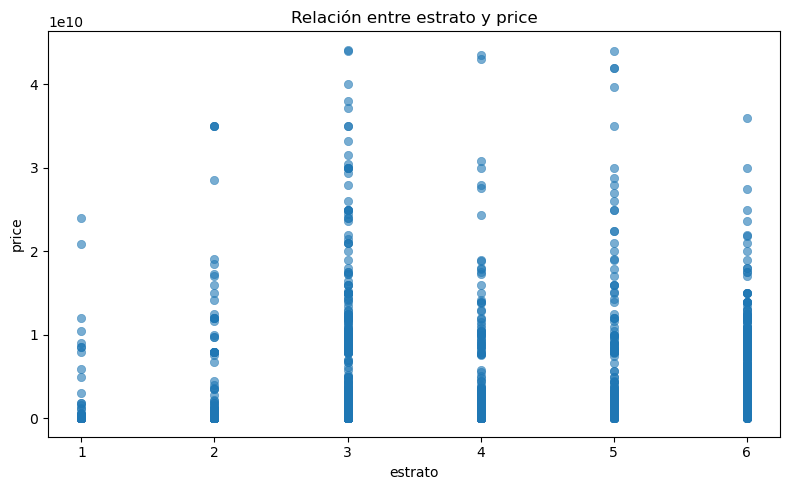

In [100]:
scatter_plot(df_no_outliers,"estrato","price")

En la Figura se muestra la relaci√≥n entre el estrato socioecon√≥mico y el precio de los inmuebles. Si bien podr√≠a esperarse una relaci√≥n creciente entre ambos, la gr√°fica revela que no existe una asociaci√≥n fuerte o lineal entre estrato y precio. Se observa una alta dispersi√≥n de precios en todos los estratos, incluyendo inmuebles de precios elevados incluso en estratos medios (3 y 4), lo que sugiere que el estrato por s√≠ solo no es un factor determinante del precio.
Este comportamiento es consistente con la din√°mica inmobiliaria de Bogot√°, donde existen zonas de estrato medio con inmuebles de alto valor debido a su ubicaci√≥n estrat√©gica, tipo de inmueble o caracter√≠sticas particulares. Asimismo, en estratos altos es posible encontrar inmuebles de menor precio debido a factores como tama√±o, estado de conservaci√≥n o antig√ºedad. Esta visualizaci√≥n refuerza lo observado en la matriz de correlaci√≥n, donde la relaci√≥n entre estrato y precio result√≥ ser baja


## modelo de machine learning para predecir precio

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = df_encoded.select_dtypes(include=["int64", "float64"]).columns
df_scaled = df_encoded.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


def linear_regression(df_):
    # üéØ 1. Define features (X) and target (y)
    numeric_cols = df_.select_dtypes(include=["int64", "float64"]).columns
    X = df_.drop(columns=["price"])
    y = df_["price"]
    # ‚úÇÔ∏è 2. Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # ü§ñ 4. Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # üìà 5. Predict and evaluate
    y_pred = model.predict(X_test)
    # y_pred_rounded = np.round(y_pred).astype(np.int64)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred, squared=False))
    print("R^2 Score:", r2_score(y_test, y_pred))
    return X_train, X_test, y_train, y_test, y_pred

X_train, X_test, y_train, y_test, y_pred = linear_regression(df_scaled)

Mean Absolute Error (MAE): 16043003.519750126
Root Mean Squared Error (RMSE): 141924489.2640374
R^2 Score: -5.048920317908907e+18


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [102]:
import pandas as pd

# Crear un DataFrame con reales y predicciones
comparacion = pd.DataFrame({
    "valor_real": y_test.values,
    "prediccion": y_pred
})

# Mostrar 10 muestras aleatorias
print(comparacion.sample(20, random_state=42))

     valor_real     prediccion
395        0.05           0.04
324        0.03           0.02
97         0.03           0.04
497        0.03           0.03
109        0.03           0.01
499        0.06 -1093012596.81
281        0.62           0.35
609        0.03           0.03
692        0.04           0.04
580        0.03           0.04
78         0.08   124033391.09
630        0.05           0.06
478        0.06           0.11
746        0.02           0.03
687        0.03   124033390.99
558        0.05           0.04
659        0.05           0.08
542        0.07           0.09
39         0.24           0.23
231        0.05           0.04


In [103]:
df_scaled_no_comodidades = df_scaled.copy()
print(f"total columns before removing commodities is: {df_scaled_no_comodidades.shape[1]}")
for col in df_comodidades.columns:
    if col in df_scaled_no_comodidades.columns:
        #print(f"col {col} will be deleted")
        df_scaled_no_comodidades = df_scaled_no_comodidades.drop(columns=[col])
df_scaled_no_comodidades = df_scaled_no_comodidades.loc[:, ~df_scaled_no_comodidades.columns.str.startswith("ubicacion_")]
print(f"total columns after removing commodities is: {df_scaled_no_comodidades.shape[1]}")
X_train, X_test, y_train, y_test, y_pred = linear_regression(df_scaled_no_comodidades)

total columns before removing commodities is: 1134
total columns after removing commodities is: 30
Mean Absolute Error (MAE): 0.01633548278765684
Root Mean Squared Error (RMSE): 0.02687206061187971
R^2 Score: 0.8189969981540839


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [104]:
X_train, X_test, y_train, y_test, y_pred = linear_regression(df_scaled[new_main_columns])

Mean Absolute Error (MAE): 0.016496090198762508
Root Mean Squared Error (RMSE): 0.027195829715414028
R^2 Score: 0.8146090785315303


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [105]:
#X_train['√Årea Urbana'].unique()

In [106]:
# # Combine features and predictions
# comparacion_completa = X_test.copy()
# comparacion_completa["valor_real"] = y_test.values
# comparacion_completa["prediccion"] = y_pred  # or y_pred_rounded if you prefer
# comparacion_completa["error"] = abs(comparacion_completa["valor_real"] - comparacion_completa["prediccion"])

# # Save to CSV
# comparacion_completa.to_csv("predicciones_completas_sin_comodidades.csv", index=False)

In [107]:
# # Combine features and predictions
# comparacion_completa = X_test.copy()
# comparacion_completa["valor_real"] = y_test.values
# comparacion_completa["prediccion"] = y_pred  # or y_pred_rounded if you prefer
# comparacion_completa["error"] = abs(comparacion_completa["valor_real"] - comparacion_completa["prediccion"])

# # Save to CSV
# comparacion_completa.to_csv("predicciones_completas.csv", index=False)

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def random_forest_regressor(df_):
    # Separar variables
    print(f"total columns are: {df_.shape[1]}")
    X = df_.drop(columns=["price"])
    y = df_["price"]
    # Dividir en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Modelo
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train, y_train)
    # Predicci√≥n
    y_pred = rf_reg.predict(X_test)
    # Evaluaci√≥n
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R¬≤ Score: {r2:.4f}")

random_forest_regressor(df_scaled)

total columns are: 1134
MAE: 0.0106
RMSE: 0.0234
R¬≤ Score: 0.8626


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [109]:
random_forest_regressor(df_scaled[new_main_columns])

total columns are: 11
MAE: 0.0115
RMSE: 0.0250
R¬≤ Score: 0.8431


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [110]:
random_forest_regressor(df_scaled_no_comodidades)

total columns are: 30
MAE: 0.0111
RMSE: 0.0238
R¬≤ Score: 0.8579


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df_scaled_with_range_price = df_scaled.copy()
df_scaled_with_range_price["range_price"] = pd.qcut(df_scaled["price"], q=7, labels=False) + 1

if "price" in df_scaled_with_range_price.columns:
    df_scaled_with_range_price=df_scaled_with_range_price.drop(columns=["price"])
df_scaled_with_range_price["range_price"] = df_scaled_with_range_price["range_price"].astype(int)

new_range_price_columns=["range_price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos","antiguedad_encoded"]

# Separar variables
X = df_scaled_with_range_price.drop(columns=["range_price"])
y = df_scaled_with_range_price["range_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predicci√≥n
y_pred = rf_clf.predict(X_test)

# Evaluaci√≥n
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6066
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.77      0.74       105
           2       0.47      0.62      0.53       104
           3       0.48      0.43      0.45       112
           4       0.54      0.45      0.49       114
           5       0.61      0.56      0.59       124
           6       0.66      0.60      0.63       104
           7       0.79      0.88      0.83        97

    accuracy                           0.61       760
   macro avg       0.61      0.61      0.61       760
weighted avg       0.61      0.61      0.60       760

Confusion Matrix:
 [[81 20  4  0  0  0  0]
 [23 64 16  1  0  0  0]
 [ 5 39 48 18  2  0  0]
 [ 5  9 25 51 22  2  0]
 [ 0  4  6 24 70 19  1]
 [ 0  0  0  0 20 62 22]
 [ 0  0  0  0  1 11 85]]


In [112]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def gradient_boost_regressor(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]  # Suponiendo precio real
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_reg.fit(X_train, y_train)
    y_pred = gb_reg.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R¬≤ Score: {r2_score(y_test, y_pred):.4f}")

gradient_boost_regressor(df_scaled)

MAE: 0.0114
RMSE: 0.0236
R¬≤ Score: 0.8599


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [113]:
gradient_boost_regressor(df_scaled[new_main_columns])

MAE: 0.0122
RMSE: 0.0246
R¬≤ Score: 0.8487


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [114]:
gradient_boost_regressor(df_scaled_no_comodidades)

MAE: 0.0121
RMSE: 0.0248
R¬≤ Score: 0.8462


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [115]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Asumiendo que ya tienes:
X = df_scaled_with_range_price.drop(columns=["range_price"])
y = df_scaled_with_range_price["range_price"].astype(int)  # Aseg√∫rate de que sean enteros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)

# Predicci√≥n
y_pred = gb_clf.predict(X_test)

# Evaluaci√≥n
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6158
Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.75      0.77       105
           2       0.53      0.73      0.62       104
           3       0.51      0.46      0.49       112
           4       0.52      0.42      0.46       114
           5       0.57      0.56      0.56       124
           6       0.64      0.59      0.61       104
           7       0.78      0.86      0.81        97

    accuracy                           0.62       760
   macro avg       0.62      0.62      0.62       760
weighted avg       0.62      0.62      0.61       760

Confusion Matrix:
 [[79 21  4  1  0  0  0]
 [12 76 10  4  2  0  0]
 [ 5 34 52 16  4  1  0]
 [ 3 11 24 48 27  1  0]
 [ 0  1 11 22 69 20  1]
 [ 0  0  0  2 18 61 23]
 [ 0  0  0  0  1 13 83]]


In [116]:
from sklearn.tree import DecisionTreeClassifier
# Asumiendo que ya tienes:
X = df_scaled_with_range_price.drop(columns=["range_price"])
y = df_scaled_with_range_price["range_price"].astype(int)  # Aseg√∫rate de que sean enteros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Evaluaci√≥n
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5171
Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.57      0.66       105
           2       0.41      0.70      0.52       104
           3       0.33      0.40      0.36       112
           4       0.32      0.10      0.15       114
           5       0.48      0.48      0.48       124
           6       0.59      0.63      0.61       104
           7       0.78      0.81      0.80        97

    accuracy                           0.52       760
   macro avg       0.53      0.53      0.51       760
weighted avg       0.52      0.52      0.50       760

Confusion Matrix:
 [[60 39  5  0  1  0  0]
 [ 9 73 16  3  3  0  0]
 [ 4 50 45  8  5  0  0]
 [ 4 14 40 11 42  3  0]
 [ 0  2 29  8 59 25  1]
 [ 0  0  1  4 12 66 21]
 [ 0  0  0  0  1 17 79]]


In [117]:
from sklearn.tree import DecisionTreeRegressor

def regression_tree_decision(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]  # No convertir a int si es continua

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = DecisionTreeRegressor(max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R¬≤ Score: {r2_score(y_test, y_pred):.4f}")
regression_tree_decision(df_scaled)

MAE: 0.0155
RMSE: 0.0348
R¬≤ Score: 0.6957


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [118]:
regression_tree_decision(df_scaled[new_main_columns])

MAE: 0.0157
RMSE: 0.0350
R¬≤ Score: 0.6933


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [119]:
regression_tree_decision(df_scaled_no_comodidades)

MAE: 0.0157
RMSE: 0.0350
R¬≤ Score: 0.6935


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [120]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mlp_regression(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]

    # Normalizar
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predicci√≥n
    y_pred = mlp.predict(X_test)

    # Evaluaci√≥n
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R¬≤ Score: {r2_score(y_test, y_pred):.4f}")

mlp_regression(df_scaled)

MAE: 0.0217
RMSE: 0.0346
R¬≤ Score: 0.6995


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [121]:
mlp_regression(df_scaled[new_main_columns])

MAE: 0.0147
RMSE: 0.0266
R¬≤ Score: 0.8221


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [122]:
mlp_regression(df_scaled_no_comodidades)

MAE: 0.0145
RMSE: 0.0260
R¬≤ Score: 0.8305


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def mlp_classification(df_):
    X = df_.drop(columns=["range_price"])
    y = df_["range_price"].astype(int)  # Aseg√∫rate de que sean clases enteras

    # Normalizar
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predicci√≥n
    y_pred = mlp.predict(X_test)

    # Evaluaci√≥n
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

mlp_classification(df_scaled_with_range_price)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def knn_classification(df_, n_neighbors=5):
    X = df_.drop(columns=["range_price"])
    y = df_["range_price"].astype(int)

    # Normalizar (obligatorio para KNN)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Divisi√≥n de datos
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predicci√≥n
    y_pred = knn.predict(X_test)

    # Evaluaci√≥n
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

knn_classification(df_scaled_with_range_price)